In [280]:
import sys
sys.path.append('..')
from video.dataset import MnistVideoCodeLMDBDataset
from video.dataloader import video_mnist_dataloader
from torchvision import utils
import numpy as np
from video.LSTM3 import LSTM3
from video.LSTM_PixelSnail3 import LSTM_PixelSnail3
from image.modified.m_vqvae import VQVAE_1
from torch import nn
import torch
from matplotlib import pyplot as plt
from image.modified.m_pixelsnail import PixelSNAIL
from tqdm import tqdm
import cv2
import itertools

In [308]:
lambda_name = 'vqvae_videomnist_2_00099'
vqvae_ckpt_path = '../video/checkpoints/videomnist/vqvae/1/00099.pt'

input_channel = 16
hidden_channel = input_channel
epoch_num = 100
batch_size = 8
device = 'cuda'
lr = 0.0004
run_num = 6
image_samples = 1

image_samples = 10
frame_len = 20
# run 3 , 4 num_frame_len =8 , run 5 num_frame_len = 5
num_frame_learn = 5



In [309]:
dataset = MnistVideoCodeLMDBDataset(lambda_name, frame_len )
loader = video_mnist_dataloader(dataset, batch_size, shuffle=False,num_workers=4)


In [310]:
vqvae_model = VQVAE_1(in_channel=1,
            channel=32,
            n_res_block=4,
            n_res_channel=16,
            embed_dim=16,
            n_embed=input_channel,
            decay=0.99, )
vqvae_model = nn.DataParallel(vqvae_model)
vqvae_model.load_state_dict(torch.load(vqvae_ckpt_path))
vqvae_model = vqvae_model.to(device)



In [311]:
videomnist_path = '../video/datasets/mnist/moving_mnist/mnist_test_seq.npy'
orginal_frames = np.load(videomnist_path)
orginal_frames = orginal_frames.swapaxes(0, 1).astype(np.float32)
orginal_frames[orginal_frames > 0] = 1.


In [312]:
input_size = (16,16)
input_channel = 16
device = 'cuda'


hidden_channel = 64

channel = 32
cnn_kernel_size = 5
kernel_size = 5
n_block = 5
n_res_block = 3
n_res_channel = 32
dropout = 0.1
n_out_res_block = 3
n_cond_res_block = 4
cond_res_channel = 32
lr = 0.0001
epoch_num = 100


In [313]:
lstm_model = LSTM3( input_channel= input_channel,hidden_channel= hidden_channel, device=device)

            
pixel_model = PixelSNAIL(
            shape = [input_size[0], input_size[1]],
            n_class = input_channel,
            cond_channel = hidden_channel+ input_channel,
            channel = channel,
            kernel_size = kernel_size,
            n_block = n_block,
            n_res_block = n_res_block,
            res_channel = n_res_channel,
            dropout=dropout,
            n_out_res_block=n_out_res_block,
            n_cond_res_block=n_cond_res_block,
            cond_res_channel=cond_res_channel,
        )


In [314]:
lstmpixelsnail_ckpt_path = f'../video/checkpoints/videomnist/vqvae-lstm-pixelsnail/{run_num}/00099.pt'

lstmpixelsnail_model = LSTM_PixelSnail3(lstm_model,pixel_model)
lstmpixelsnail_model = nn.DataParallel(lstmpixelsnail_model)

lstmpixelsnail_model.load_state_dict(torch.load(lstmpixelsnail_ckpt_path))

lstmpixelsnail_model = lstmpixelsnail_model.to(device)



In [315]:
def get_vqvae_decode(sample):
    sample = vqvae_model.module.decode_code(sample)
    sample = sample.cpu().detach()
    sample = sample.squeeze()
    sample = (sample > 0.5).float()
    return sample

In [316]:
def show_sample(sample):
    sample = get_vqvae_decode(sample)
    plt.imshow(sample[0,:,:])
    plt.show()


In [317]:
def model_learn(lstmpixelsnail_model , inputs,last_frame, cells_state = None):
    
    
    outs = []
    size = inputs.size()
    for i in range(size[1]-1):
        inp = torch.cat([inputs[:,i:i+2,:,:,:],last_frame.unsqueeze(dim=1)],dim=1)
        pred, cells_state = lstmpixelsnail_model(inp, cells_state) 
        outs.append(pred)
#     state = []
#     for state in cells_state:
#         states.append([state[0].detach(),state[1].detach()])
        
    return outs, cells_state

In [318]:
def _to_one_hot(y, num_classes):
    scatter_dim = len(y.size())
    y_tensor = y.view(*y.size(), -1)
    zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)

    return zeros.scatter(scatter_dim, y_tensor, 1).permute(0, 3, 1, 2)


In [319]:
def one_hot_to_int(y):
#     print('y {}'.format(y.size()))

    y_trans = y.permute(0, 2, 3, 1)
    y_trans = y_trans.argmax(dim=-1)
    return y_trans


In [320]:
def callback(results,data, run_num):
    imgs = []
    for preds,frames in zip(results,data):
        preds_decode = []
        frames_decode = []
        with torch.no_grad():
            for i,pred in enumerate(preds):
                vqvae_model.eval()
                pred_decode = get_vqvae_decode(pred)
                frame_decode = get_vqvae_decode(frames[:,i,:,:])
                frames_decode.append(frame_decode[0,:,:])
                preds_decode.append(pred_decode[0,:,:])
        ps =torch.cat(preds_decode,dim=1)
        fs = torch.cat(frames_decode,dim=1)
        img = torch.cat([ps,fs],dim=0)
        if len(imgs)==0:
            imgs = img
        else:
            imgs = torch.cat([imgs,img],dim=0)
    plt.imshow(imgs)
#         plt.show()
#     cv2.imwrite('./output_samples/{}.png'.format(run_num),imgs.cpu().detach().numpy()) 
    plt.savefig('./output_samples/{}.png'.format(run_num))

#     plt.figure(figsize=(20,10))

In [321]:
def get_pixel_snail_out(cond, size,temperature=1.0):
    cache = {}
    row = torch.zeros( *size).to('cuda')
#     print(row.size())
#     print(cond.size())
    for i in tqdm(range(size[2])):
        for j in range(size[3]):
            out, cache = pixel_model(row[: ,:, : i + 1, :], condition=cond, cache=cache)
            prob = torch.softmax(out[:, :, i, j] / temperature, 1)
            sample = torch.argmax(prob, 1, keepdim=False)
            sample = cuda_to_one_hot(sample, size[1]).float()

            row[:,:, i, j] = sample
    return row

In [322]:
def cuda_to_one_hot(y, num_classes):
    scatter_dim = len(y.size())
    y_tensor = y.view(*y.size(), -1)
    zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype).to('cuda')

    return zeros.scatter(scatter_dim, y_tensor, 1)

def get_sample(lstm_model,pixel_model ,  input_, last_frame , cells_state, temperature=1.0):
    
    size = input_[:,0,:,:,:].size()
    
    lstm_out, cells_state = lstm_model(input_[:,0,:,:,:], cells_state)
    pixel_cond = torch.cat([lstm_out,last_frame],dim=1)
    row = get_pixel_snail_out(pixel_cond, size)

    return row, cells_state


In [323]:
def visual(outs,ins):
    size = ins[:,0,:,:,:].size()
    pixel_model.eval()
    with torch.no_grad():
        for lstm_out in outs:
            last_frame= ins[:, -1, :, :, :]
            pixel_cond = torch.cat([lstm_out,last_frame],dim=1)

            raw = get_pixel_snail_out(pixel_cond, size) 
            sample_decode = get_vqvae_decode(one_hot_to_int(raw))
            plt.imshow(sample_decode[0,:,:])
            plt.show()


100%|██████████| 16/16 [00:06<00:00,  2.29it/s]


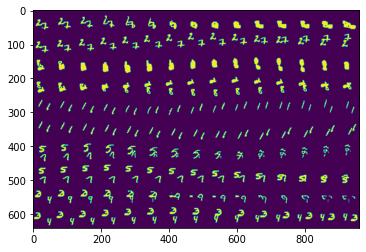

In [324]:
lstmpixelsnail_model.train()
preds =[]
torch.backends.cudnn.enabled = False
# lstm_model.eval()
# pixel_model.eval() 
results= []
data = []
with torch.no_grad():
    for iter_, (frames, video_inds, frame_inds) in enumerate(loader):
        if 5<iter_ <=10:
            inputs_ = []
            f0 = torch.zeros(frames.shape[0], 1, input_channel,frames.shape[2], frames.shape[3])
            f0 = f0.to(device)
            inputs_.append(f0)
            
            for i in range(frames.shape[1]):

                input_ = _to_one_hot(frames[:, i, :, :], input_channel).float()
                input_ = input_.to(device)
                inputs_.append(input_.unsqueeze(dim=1))

            inputs_ = torch.cat(inputs_, dim=1)
            
            
            outs, states = model_learn(lstmpixelsnail_model , inputs_[:,:num_frame_learn+1,:,:,:], inputs_[:,num_frame_learn+1,:,:,:] )
#             for i, out in enumerate(outs):
#                 pred = one_hot_to_int(out)
#                 callback(pred[:,:,:],frames[:,i,:,:].to('cuda'))
                
#             visual(outs,inputs_[:,:num_frame_learn+2,:,:,:])
#             samples = None
            new_sample =inputs_[:, num_frame_learn  , :, :, :].unsqueeze(dim=1)
            preds = []
            for i in range(num_frame_learn ,frames.size()[1]):
                new_sample,states = get_sample(lstm_model,pixel_model ,new_sample ,inputs_[:, num_frame_learn +1, :, :, :] , states )
                pred = one_hot_to_int(new_sample)
                preds.append(pred)
                frames = frames.to('cuda')
                
                new_sample = new_sample.unsqueeze(1)
            results.append(preds)
            data.append(frames[:,num_frame_learn:frames.size()[1],:,:])
    callback(results,data,run_num)
#                 else:
#                     pred = torch.cat((samples,sample.unsqueeze(1)),dim=1)
                
#                 preds.append(sample)
                
#                 states = model_learn(lstm_model, cnn_model,pixel_model , new_sample.unsqueeze(dim=0) ,states)
                
#                 sample = new_sample
                   

In [325]:
sample_int = one_hot_to_int(samples[0,:,:,:])
torch.backends.cudnn.enabled = False
callback(sample_int,frames[0,frame_learn:frame_pred+frame_learn,:,:],frame_pred)

NameError: name 'samples' is not defined

In [ ]:
print(samples[0,:,:,:].shape)

In [ ]:
_input = inputs_[:,1,:,:,:]
# _input =_input.to('cuda')
# one = _to_one_hot(_input,16)
rel = one_hot_to_int(_input)
print(rel)
print(frames[:, 0, :, :])
# print(_input.shape)
# for i in range(_input.shape[1]):
#     print(_input[:,i,:,:])

In [ ]:
a = torch.randn(4, 4)
print(a)
torch.argmax(a, dim=0,keepdim=True)